## Digging into COCO

Notebooks offer a convenient way to analyze visual datasets. Code and visualizations can live in the same place, which is exactly what CV/ML often requires. With that in mind, being able to find problems in visual datasets is the first step towards improving them. This notebook walks us though each "step" (i.e., a notebook cell) of digging for problems in an image dataset. First, we'll need to install the `fiftyone` package with `pip`.

*If working in Google's Colaboratory, be sure to [enable a GPU runtime](https://colab.research.google.com/drive/1P7okDVh6viCIOkii6UAF2O9sTAcKGNWq) before running any cell.*

In [ ]:
!pip install fiftyone

Next, we can download and load our dataset. We will be using the [`COCO-2017`](https://voxel51.com/docs/fiftyone/user_guide/dataset_zoo/datasets.html#coco-2017) validation split. Let's also take a moment to visualize the ground truth detection labels using the [`FiftyOne App`](https://voxel51.com/docs/fiftyone/user_guide/app.html). The following code will do all of this for us.

 100% |██████|    6.1Gb/6.1Gb [22.3s elapsed, 0s remaining, 291.4Mb/s]      
Extracting images to '/root/fiftyone/coco-2017/tmp-download/val2017'
 100% |██████|    1.9Gb/1.9Gb [7.2s elapsed, 0s remaining, 298.2Mb/s]       
Extracting annotations to '/root/fiftyone/coco-2017/tmp-download/annotations/instances_val2017.json'
loading annotations into memory...
Done (t=0.63s)
creating index...
index created!
 100% |█████| 5000/5000 [2.0m elapsed, 0s remaining, 43.7 samples/s]      
Dataset info written to '/root/fiftyone/coco-2017/info.json'
Loading 'coco-2017' split 'validation'
 100% |█████| 5000/5000 [43.1s elapsed, 0s remaining, 113.9 samples/s]      
Dataset 'coco-2017-validation' created



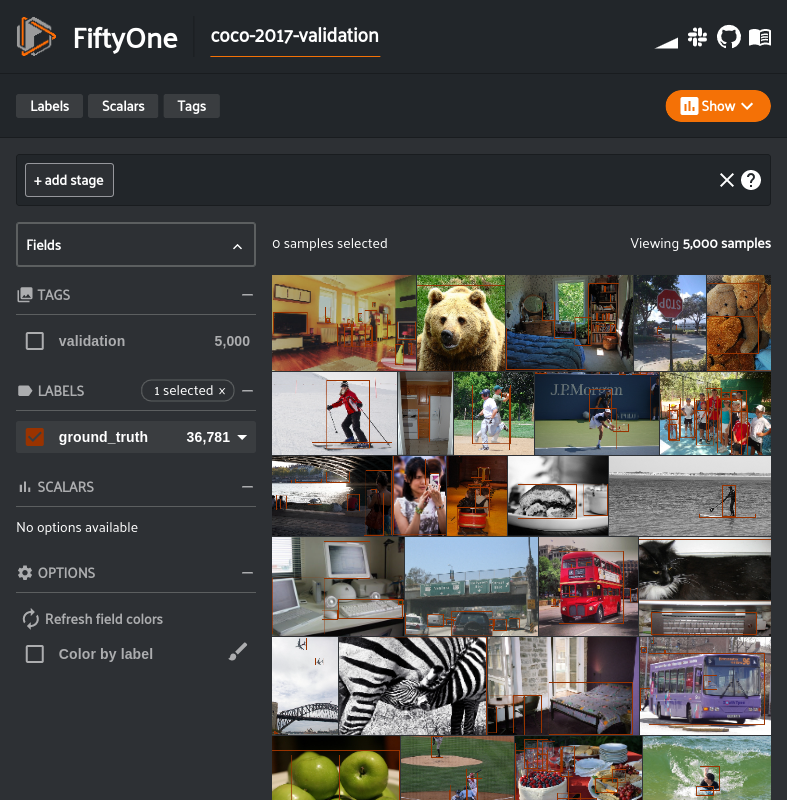

In [2]:
import fiftyone as fo
import fiftyone.zoo as foz

dataset = foz.load_zoo_dataset("coco-2017", split="validation")
session = fo.launch_app(dataset)

We have our [`COCO-2017`](https://voxel51.com/docs/fiftyone/user_guide/dataset_zoo/datasets.html#coco-2017) validation dataset loaded, now let's download and load our model and apply it to our validation dataset. We will be using the [`faster-rcnn-resnet50-fpn-coco-torch`](https://voxel51.com/docs/fiftyone/user_guide/model_zoo/models.html#faster-rcnn-resnet50-fpn-coco-torch) pre-trained model from the [`FiftyOne Model Zoo`](https://voxel51.com/docs/fiftyone/user_guide/model_zoo/index.html). Let's apply the predictions to a new label field predictions, and limit the application to detections with a confidence greater than or equal to `0.6`.

In [3]:
model = foz.load_zoo_model("faster-rcnn-resnet50-fpn-coco-torch")
dataset.apply_model(model, label_field="predictions", confidence_thresh=0.6)

 100% |██████|    1.2Gb/1.2Gb [1.6s elapsed, 0s remaining, 727.7Mb/s]         
 100% |█████| 5000/5000 [31.0m elapsed, 0s remaining, 2.7 samples/s]      


Let's focus on issues related vehicle detections and consider all buses, cars, and trucks vehicles and ignore any other detections, in both the ground truth labels and our predictions.

The following filters our dataset to a view containing only our vehicle detections, and renders the view in the App. Because we are in a notebook, you will notice that each time a new App cell is opened, the previously active App cell will be replaced with a screenshot of itself. Neato!


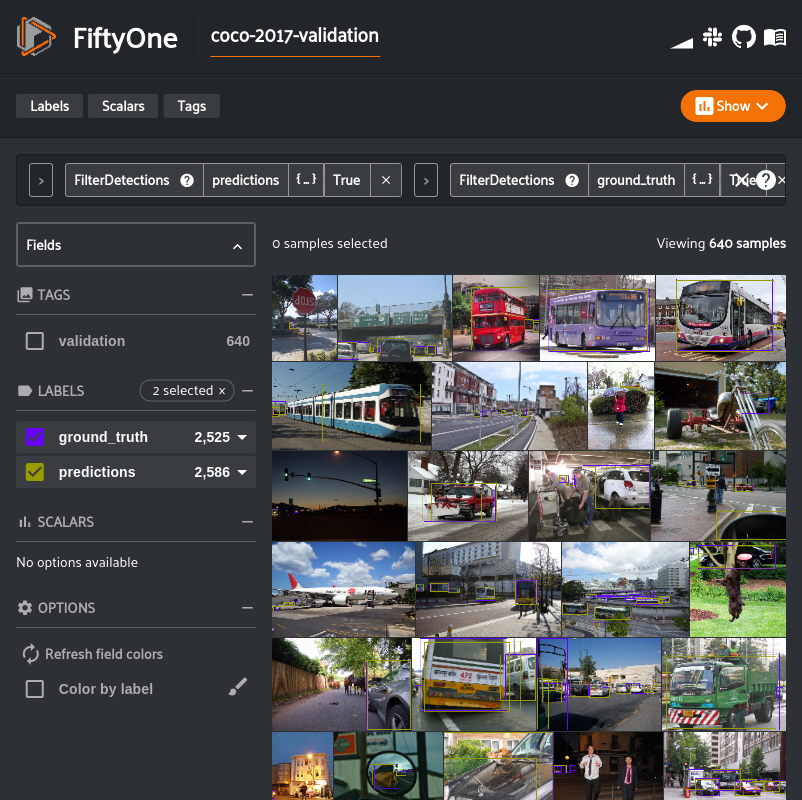

In [4]:
from fiftyone import ViewField as F

vehicle_labels = ["bus","car", "truck"]
only_vehicles = F("label").is_in(vehicle_labels)

vehicles = (
    dataset
    .filter_labels("predictions", only_vehicles, only_matches=True)
    .filter_labels("ground_truth", only_vehicles, only_matches=True)
)

session.view = vehicles

Now that we have our predictions, we can evaluate the model. We'll use an [`evaluate_detections()`](https://voxel51.com/docs/fiftyone/api/fiftyone.utils.eval.coco.html?highlight=evaluate_detections#fiftyone.utils.eval.coco.evaluate_detections) utility method provided by FiftyOne that uses the COCO evaluation methodology.

In [5]:
from fiftyone.utils.eval import evaluate_detections

evaluate_detections(vehicles, "predictions",  gt_field="ground_truth", iou=0.75)

Evaluating detections...
 100% |███████| 640/640 [10.1s elapsed, 0s remaining, 67.8 samples/s]      


[`evaluate_detections()`](https://voxel51.com/docs/fiftyone/api/fiftyone.utils.eval.coco.html?highlight=evaluate_detections#fiftyone.utils.eval.coco.evaluate_detections) has populated various pieces of data about the evaluation into our dataset. Of note is information about which predictions were not matched with a ground truth box. The following view into the dataset lets us look at only those unmatched predictions. We'll sort by confidence, as well, in descending order.


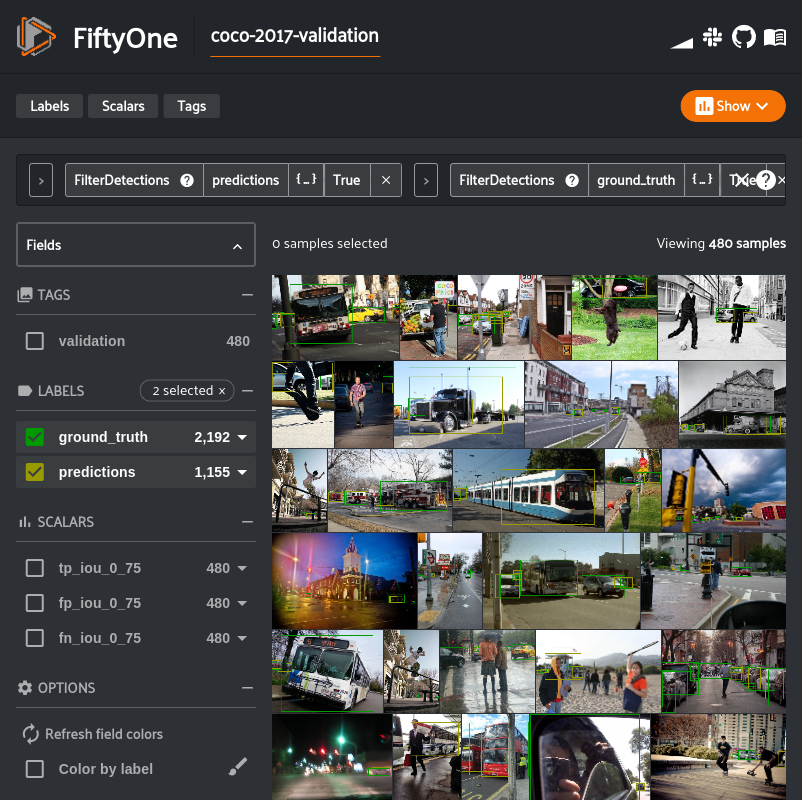

In [6]:
filter_vehicles = F("ground_truth_eval.matches.0_75.gt_id") == -1

unmatched_vehicles = (
    vehicles
    .filter_labels("predictions", filter_vehicles, only_matches=True)
    .sort_by(F("predictions.detections.confidence"), reverse=True)
)

session.view = unmatched_vehicles

Double-clicking on a few images, we can see that the most common reason for an unmatched prediction is that there is a label mismatch. It is not surprising, as all three of these classes are in the `vehicle` supercategory. Trucks and cars are often confused in human annotation and model prediction.

Looking beyond class confusion, though, let's take a look at the first two samples in our unmatched predictions view.




<table>
<td>
<img src="https://drive.google.com/uc?export=view&id=1kzHI6fprEKd69A0nMk1PkCIaNl7199Zt"/>
</td>
<td>
<img src="https://drive.google.com/uc?export=view&id=1Et9HkZGv9-9sHStfxGXsaoaGjXCbB3la"/>
</td>
<td>
<img src="https://drive.google.com/uc?export=view&id=18_7gO-AyR7egHUz6FSipgFhVlD_98S8p"/>
</td>
</table>
<b>The truncated car in the right of the image has too small of a bounding box. The unmatched prediction is far more accurate, but did not meet the IoU threshold.</b>



The very first sample, found in the pictures above, has an annotation mistake. The truncated car in the right of the image has too small of a ground truth bounding box (pink). The unmatched prediction (yellow) is far more accurate, but did not meet the IoU threshold.

<table>
<td>
<img src="https://drive.google.com/uc?export=view&id=1TrNRcc9mMzozGLeLQEICWTgJE374KOic"/>
</td>

<td>
<img src="https://drive.google.com/uc?export=view&id=1jM-kNn5HAivXffwPN65fllVgg9coO6fc"/>
</td>
</table>
<b>The predicted box of the car in the shadow of the trees is correct, but it is not labeled in the ground truth.</b>

The second sample found in our unmatched predictions view contains a different kind of annotation error. A more egregious one, in fact. The correctly predicted bounding box (yellow) in the image has no corresponding ground truth. The car in the shade of the trees was simply not annotated.

Manually fixing these mistakes is out of the scope of this example, as it requires a large feedback loop. [FiftyOne](http://fiftyone.ai) is dedicated to making that feedback loop possible (and efficient), but for now let's focus on how we can answer questions about model performance, and confirm the hypothesis that our model does in fact confuse buses, cars, and trucks quite often.

We'll do this by reevaluating our predictions with buses, cars, and trucks all merged into a single `vehicle` label. The following creates such a view, clones the view into a separate dataset so we'll have separate evaluation results, and evaluates the merged labels.

Evaluating detections...
 100% |███████| 640/640 [6.6s elapsed, 0s remaining, 102.2 samples/s]      



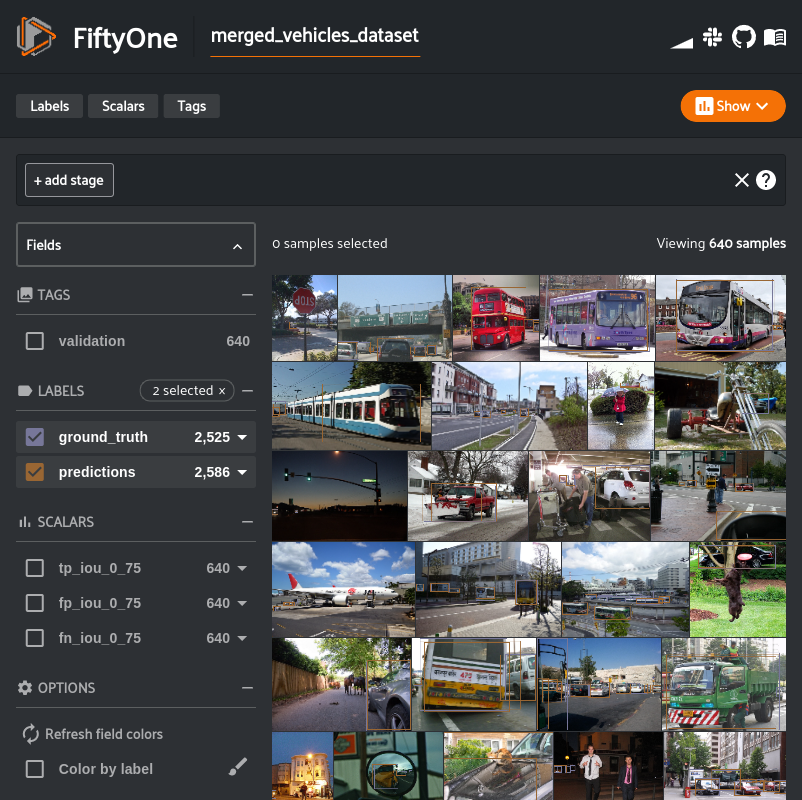

In [7]:
vehicle_labels = {
    label: "vehicle" for label in ["bus","car", "truck"]
}

merged_vehicles_dataset = (
    vehicles
    .map_labels("ground_truth", vehicle_labels)
    .map_labels("predictions", vehicle_labels)
    .exclude_fields(["tp_iou_0_75", "fp_iou_0_75", "fn_iou_0_75"])
    .clone("merged_vehicles_dataset")
)

evaluate_detections(merged_vehicles_dataset, "predictions", gt_field="ground_truth", iou=0.75)

session.dataset = merged_vehicles_dataset

Now we have evaluation results for the originally segmented bus, car, and truck detections and the merged detections. We can now simply compare the number of true positives from the original evaluation, to the number of true positives in the merged evaluation.

In [9]:
original_tp_count = vehicles.sum("tp_iou_0_75")
merged_tp_count = merged_vehicles_dataset.sum("tp_iou_0_75")

print("Original Vehicles True Positives: %d" % original_tp_count)
print("Merged Vehicles True Positives: %d" % merged_tp_count)

Original Vehicles True Positives: 1431
Merged Vehicles True Positives: 1515


We can see that before merging the `bus`, `car`, and `truck` labels there were 1,431 true positives. Merging the three labels together resulted in 1,515 true positives.

We were able to confirm our hypothesis! Albeit, a quite obvious one. But we now have a data-backed understanding a common failure mode of this model. And now this entire experiment can be shared with others. The following will screenshot the last active App window, so all outputs can be statically viewed by others.

In [8]:
session.freeze() # Screenshot the active App window for sharing

Thanks for following along! The FiftyOne project can be found on [GitHub](https://medium.com/r/?url=https%3A%2F%2Fgithub.com%2Fvoxel51%2Ffiftyone). If you agree that the CV/ML community needs an open tool to solve its data problems, give us a star!